# Mall Customer Clustering : First Small Project with KMeans

In [40]:
# Importez les bibliothèques
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

### Chargement du dataset

In [41]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Analyse exploratoire

In [42]:
# Forme
data.shape

(200, 5)

In [43]:
# Informations importantes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [44]:
# Valeurs manquantes
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [45]:
# Doublons
data.duplicated().sum()

np.int64(0)

In [1]:
# Distribution de l'âge
fig, axes = plt.subplots(figsize=(15,5))
sns.kdeplot(ax = axes, x=data[(data['Age'] & (data['Genre'] == 'Male')])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2372108685.py, line 3)

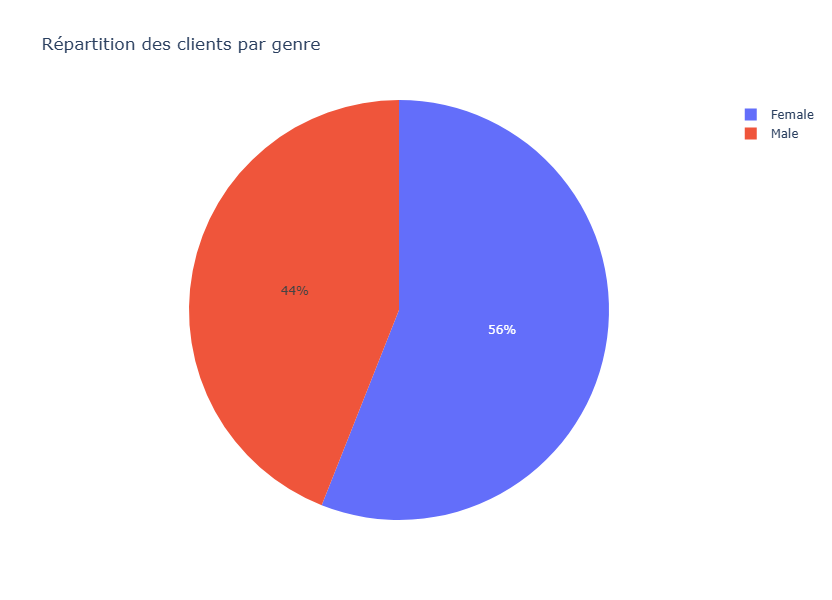

In [48]:
# Répartition des clients selon le genre
fig = px.pie(data_frame=data, 
       names='Genre', 
       title='Répartition des clients par genre'
      )
fig.update_layout(width=800, height = 600)

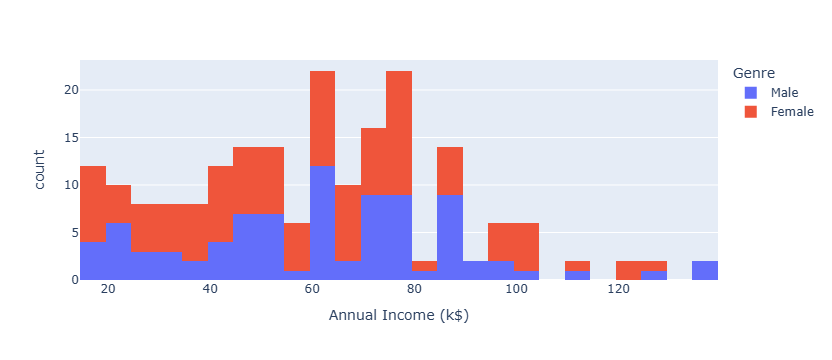

In [49]:
# Distribution du salaire annuel
px.histogram(data_frame=data, x = 'Annual Income (k$)', color='Genre', nbins=50)

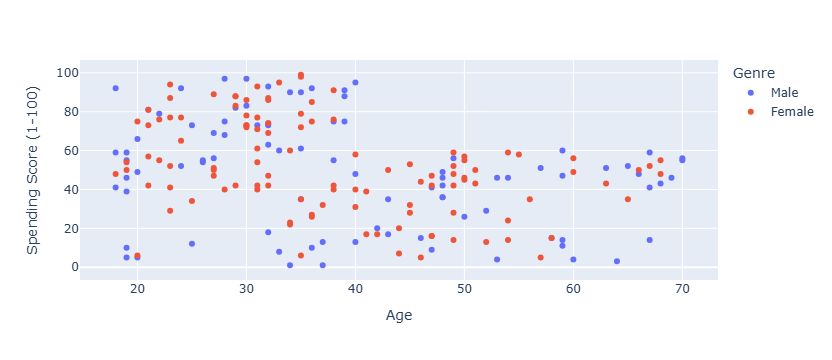

In [50]:
# Relations entre l'âge et le Spending Score
px.scatter(data_frame=data, x='Age', y='Spending Score (1-100)', color='Genre')

### Preprocessing

In [51]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

In [52]:
cat_features = make_column_selector(dtype_include=object)
num_features = make_column_selector(dtype_exclude=object)

encoder_scaler= ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_features), 
        ('num', StandardScaler(), num_features)
    ]
)
data.drop('CustomerID', axis=1, inplace=True)

### Feature Engineering

In [53]:
data['IncomePerAge (k$)'] = data['Annual Income (k$)'] / data['Age']
data['AdjustedSpending'] = (data['Spending Score (1-100)'] * data['Annual Income (k$)']) / 100
data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),IncomePerAge (k$),AdjustedSpending
0,Male,19,15,39,0.789474,5.85
1,Male,21,15,81,0.714286,12.15
2,Female,20,16,6,0.800000,0.96
3,Female,23,16,77,0.695652,12.32
4,Female,31,17,40,0.548387,6.80


### Determiner le nombre de clusters

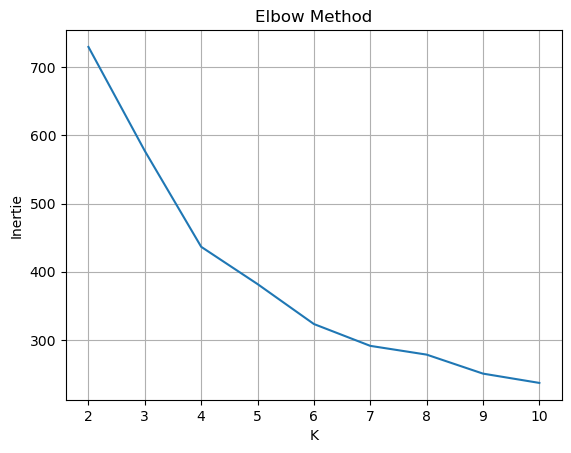

In [54]:
# 1. Methode elbow
inertie_list = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    data_transformed = encoder_scaler.fit_transform(data)
    model.fit(data_transformed)
    inertie_list.append(model.inertia_)

fig, ax = plt.subplots(1)
ax.plot(range(2, 11), inertie_list)
ax.set_xlabel('K')
ax.set_ylabel('Inertie')
ax.set_title('Elbow Method')
plt.grid()

In [55]:
# L'inertie pour chaque valeur de K
vue = pd.DataFrame({
    'K' : range(2, 11),
    'Inertie' : inertie_list
})
vue

,K,Inertie
0,2,729.651867
1,3,577.149551
2,4,436.573518
3,5,381.919857
4,6,323.319092
5,7,291.313506
6,8,278.469931
7,9,250.605699
8,10,236.967379


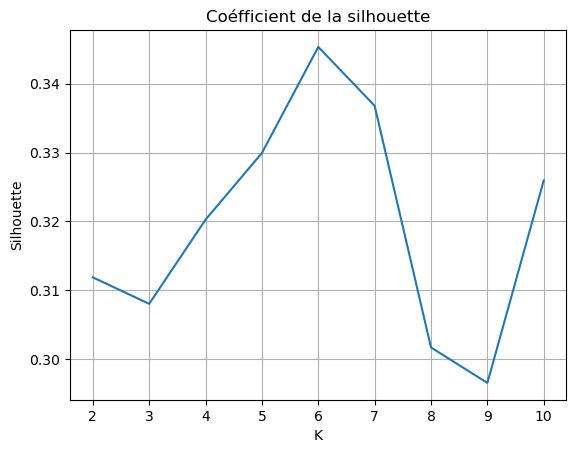

In [56]:
# 2. Coéficient de la silhouette
from sklearn.metrics import silhouette_score
silhouette_list = []
for k in range(2, 11):
    model = KMeans(n_clusters=k)
    data_transformed = encoder_scaler.fit_transform(data)
    model.fit(data_transformed)
    silhouette_list.append(silhouette_score(data_transformed, model.labels_))
    
fig, ax = plt.subplots(1)
ax.plot(range(2, 11), silhouette_list)
ax.set_xlabel('K')
ax.set_ylabel('Silhouette')
ax.set_title('Coéfficient de la silhouette')
plt.grid()

**Prenons une valeur de K = 6**

### Appliquer KMeans

In [57]:
model = KMeans(n_clusters=6, random_state=42)
model.fit(data_transformed)

KMeans(n_clusters=6, random_state=42)

In [58]:
# Label des clusters pour chaque clients
labels = model.labels_
data['Cluster'] = labels
data.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),IncomePerAge (k$),AdjustedSpending,Cluster
0,Male,19,15,39,0.789474,5.85,2
1,Male,21,15,81,0.714286,12.15,2
2,Female,20,16,6,0.800000,0.96,4
3,Female,23,16,77,0.695652,12.32,2
4,Female,31,17,40,0.548387,6.80,4


In [59]:
# les centroïdes
model.cluster_centers_

array([[ 0.51923077,  0.48076923,  1.14661088, -0.20634981, -0.10556478,
        -0.75173006, -0.19734914],
       [ 0.53846154,  0.46153846, -0.44191719,  0.99158305,  1.23950275,
         0.98067496,  1.77404654],
       [ 0.62068966,  0.37931034, -0.91477782, -1.22568618,  0.85032605,
        -0.67097346, -0.46137666],
       [ 0.4516129 ,  0.5483871 ,  0.1126274 ,  1.12370799, -1.33771584,
         0.68401998, -0.68654791],
       [ 0.65      ,  0.35      ,  0.47007182, -1.33249477, -1.2287024 ,
        -1.21481149, -1.12160352],
       [ 0.65517241,  0.34482759, -0.99149394, -0.02005869, -0.0506019 ,
         0.80667174, -0.06312694]])

In [60]:
# Inertie finale 
model.inertia_

323.31909169409397

In [61]:
# Moyenne des variables par cluster
data.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'IncomePerAge (k$)', 'AdjustedSpending']].mean()

,Age,Annual Income (k$),Spending Score (1-100),IncomePerAge (k$),AdjustedSpending
Cluster,,,,,
0,54.826923,55.153846,47.480769,1.035760,25.957500
1,32.692308,86.538462,82.128205,2.685583,71.014103
2,26.103448,28.448276,72.103448,1.112667,19.923103
3,40.419355,90.000000,15.741935,2.403069,14.776774
4,45.400000,25.650000,18.550000,0.594753,4.833500
5,25.034483,60.034483,48.896552,2.519874,29.025172


# Relations certaines valeurs en visualisant les clusters

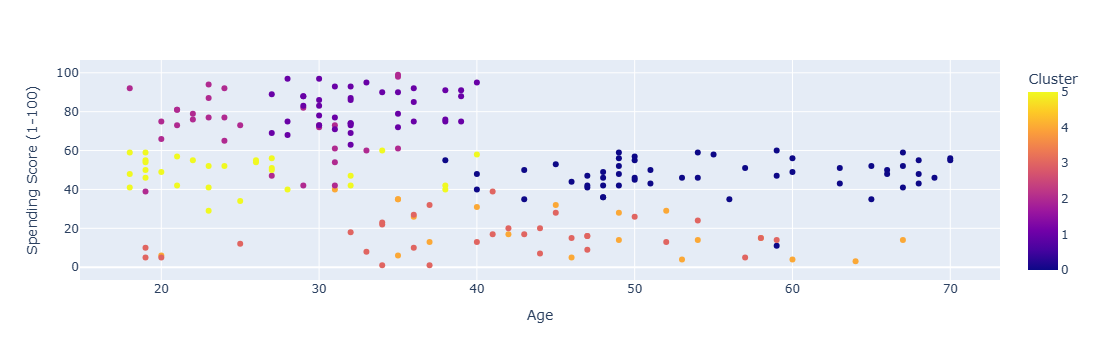

In [62]:
px.scatter(data_frame=data, x = 'Age', y='Spending Score (1-100)', color='Cluster')

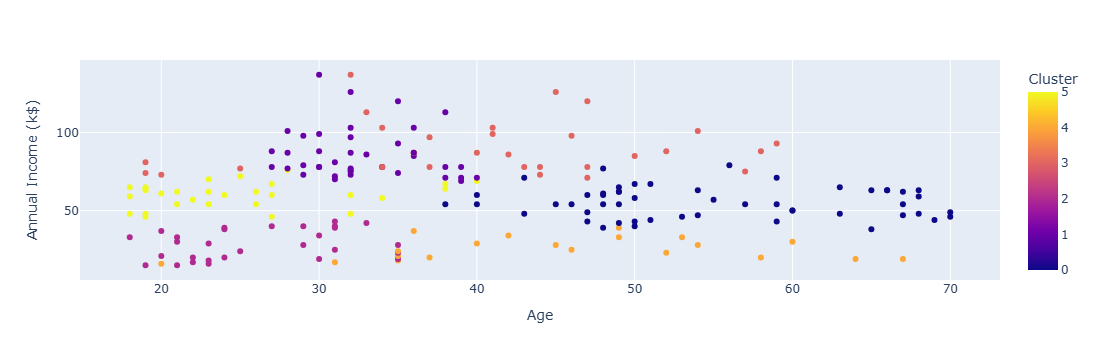

In [63]:
# Petite visualisation
px.scatter(data_frame=data, x = 'Age',y ='Annual Income (k$)', color='Cluster')

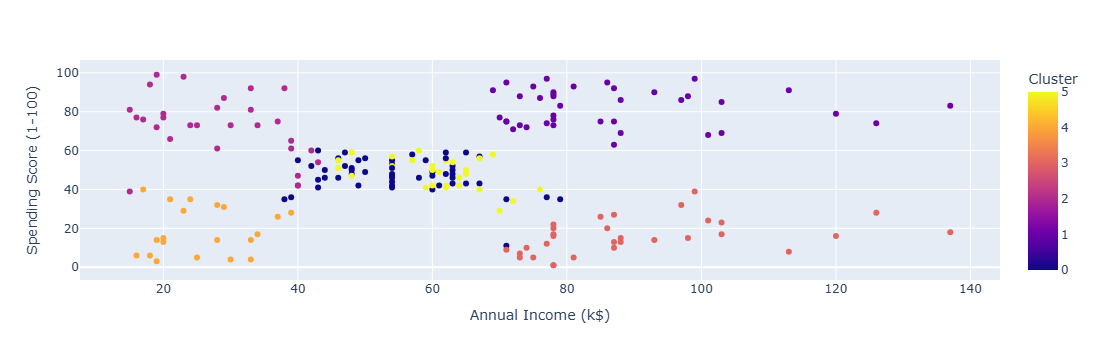

In [64]:
px.scatter(data_frame=data, x='Annual Income (k$)', y='Spending Score (1-100)', color='Cluster')

**Nous constatons que certains groupes sont déjà entrain de se former**

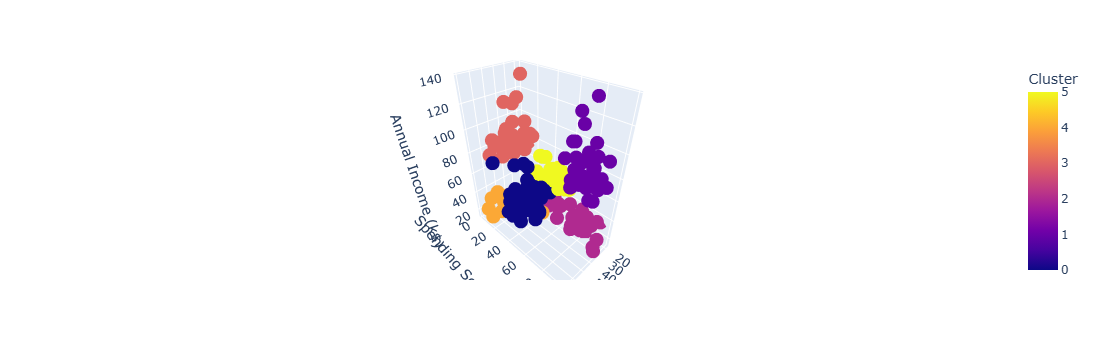

In [65]:
# Petite visualisation 3D
px.scatter_3d(data_frame=data, x=data['Age'], 
              y=data['Spending Score (1-100)'], 
              z=data['Annual Income (k$)'], 
              color=data['Cluster'])
